# Lab 5: Spam Detection

**Deadline**: Monday, Mar 14, 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Hossein Yousefi <hossein.yousefi@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1Hsmb43lOXLCcggFP3eqeAYP0fPVE4yMZ/view?usp=sharing

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
WORKING_DIR = "/content/drive/MyDrive/Documents/Uni/School/FifthYear/APS360/lab5"
os.chdir(WORKING_DIR)
DATASET_PATH = "SMSSpamCollection"

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-12 16:38:35--  http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   903KB/s    in 0.2s    

2022-03-12 16:38:35 (903 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
seen = set()
for line in open(DATASET_PATH):
    category = line.split()[0]
    if category not in seen:
      print(line)
      seen.add(category)

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



| Spam Message | Non-Spam Message |
| --- | --- |
| spam | ham |

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open(DATASET_PATH):
    category = line.split()[0]
    if category == "spam":
      spam += 1
    elif category == "ham":
      ham += 1
    else:
      raise

print("Number of spam messages =", spam)
print("Number of non-spam messages =", ham)

Number of spam messages = 747
Number of non-spam messages = 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

---
**Advantages**
1. Misspelled words or words that is not in the `Sentiment140` dataset will not be treated as a special `unknown` token; instead, they will be treated like other characters and be fed into the RNN. 
2. There is a small number of characters, making it easier to use one-hot encoding on all of the characters without the size of the encoding being too large. 


**Disadvantages**
1. It is likely more computationally expensive than the word-level counterpart because it requires deeper networks to model long-term dependencies. 
2. It is likely to have lower accuracy than the word-level counterpart, since the grouping of each individual word is left for the network to learn, instead of directly given. Characters do not convey the meanings that are represented by words. 


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [8]:
import torchtext
import random

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                        tokenize=lambda x: x, # because are building a character-RNN
                                        include_lengths=True, # to track the length of sequences, for batching
                                        batch_first=True,
                                        use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                        use_vocab=False,     # don't need to track vocabulary
                                        is_target=True,      
                                        batch_first=True,
                                        preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('email', text_field)]
dataset = torchtext.legacy.data.TabularDataset("/Users/dakuang/Downloads/Project_1/test.csv", # name of the file
                                              "csv",               # fields are separated by a tab
                                              fields)


# print(dataset[0].sms)
# print(dataset[0].label)

random.seed(1000)

train, valid_test  = dataset.split(split_ratio=0.6, random_state= random.getstate())
valid, test = valid_test.split(split_ratio=0.5, random_state= random.getstate())
print("train size:", len(train))
print("val size:", len(valid))
print("test size:", len(test))


AttributeError: module 'torchtext.data' has no attribute 'Field'

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

---
If the training set is imbalanced, then the network would be more likely to predict an input to be the one that it has seen more during training; in this case, there are more non-spam messages than spam messages, so the network is more likely to predict non-spam given a message. If we make the dataset roughly balanced, then the network won't have this inherent bias. 

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7ff19d6c68d0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, '0': 13, 'h': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '7': 37, '4': 38, 'N': 39, 'x': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'P': 48, 'M': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'Y': 56, '/': 57, 'F': 58, 'G': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ';': 73, ')': 74, '+': 75, 'Q': 76, '"': 77, '(': 78, 'q': 79, '#': 80, '@': 81, '=': 82, 'Z': 83, '>': 84, 'ü': 85, 'Ü': 86, '<': 87, '_': 88, '$': 89, '\x92': 90, '‘': 91, '[': 92, ']': 93, '¡': 94, '%': 95, '|': 96, '…': 97, '’':

---
`text_field.vocab.stoi` provides a dictionary mapping token
haracters set to their corresponding numerical identifier.
`text_field.vocab.itos` provides a list of token characters set indexed by their numerical identifier. 

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

---
`<unk>` represents "unknown token" which is used when a given word is not in the vocabulary (Out-of-Vocabulary or OOV). 

`<pad>` represents "padding" which is used to pad short sentences to ensure equial lengh input to the network. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
train_iter_iterator = iter(train_iter)

for i in range(10):
  print("-"*20 + f" {i+1} " + "-"*20)
  batch = next(train_iter_iterator)
  max_len = batch.sms[0].shape[1]
  print("Maximum length of input sequence:", max_len)
  print("Number of <pad> tokens:", sum(max_len - batch.sms[1]).item())
  
  # print(len(batch))
  # print(batch.sms)
  # print(batch.label)
  # print(len(batch.sms))
  # print(batch)


    

-------------------- 1 --------------------
Maximum length of input sequence: 32
Number of <pad> tokens: 17
-------------------- 2 --------------------
Maximum length of input sequence: 107
Number of <pad> tokens: 28
-------------------- 3 --------------------
Maximum length of input sequence: 150
Number of <pad> tokens: 11
-------------------- 4 --------------------
Maximum length of input sequence: 65
Number of <pad> tokens: 47
-------------------- 5 --------------------
Maximum length of input sequence: 134
Number of <pad> tokens: 30
-------------------- 6 --------------------
Maximum length of input sequence: 148
Number of <pad> tokens: 17
-------------------- 7 --------------------
Maximum length of input sequence: 158
Number of <pad> tokens: 0
-------------------- 8 --------------------
Maximum length of input sequence: 40
Number of <pad> tokens: 39
-------------------- 9 --------------------
Maximum length of input sequence: 124
Number of <pad> tokens: 55
-------------------- 10

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
len(text_field.vocab) # Size of one-hot vector

113

In [ ]:
class SpamNet(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_classes):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.ident = torch.eye(vocab_size)
        self.name = "SpamNet"

        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.ident[x]
        x = x.to(device)

        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                         torch.mean(out, dim=1)], dim=1)
        # out = self.fc(out[:, -1, :])
        # out = self.fc(torch.max(out, dim=1)[0])
        out = self.fc(out)
        
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [60]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    data_iter = torchtext.legacy.data.BucketIterator(data,
                                           batch_size=len(data),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    
    for sms, label in data_iter:
        sms, label = sms[0].to(device), label.to(device)
        output = model(sms)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += label.shape[0]

    return correct / total

In [ ]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the validation set
         loss: A scalar for the average loss function over the validation set
     """
     
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        
        inputs, labels = inputs[0].to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Get the index of the max log-probability
        pred = outputs.max(1, keepdim=True)[1] 

        # Check for correctness
        corr = pred.eq(labels.view_as(pred))

        total_acc += int(corr.sum().item())
        total_loss += loss.item()
        total_epoch += len(labels)

    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch, path_prefix=""):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    if path_prefix != "" and not os.path.exists(path_prefix):
        os.makedirs(path_prefix)

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    
    return os.path.join(path_prefix, path)

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_net(net, 
              train_set, val_set,
              path_prefix="", 
              batch_size=64, 
              learning_rate=0.01, 
              num_epochs=30,
              num_workers=1,
              sanity_check=False,
              device=None,
              **kwargs):

    if not device:
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    torch.manual_seed(1000)

    train_iter = torchtext.legacy.data.BucketIterator(train_set,
                                                      device=device,
                                                      batch_size=batch_size,
                                                      sort_key=lambda x: len(x.sms), # to minimize padding
                                                      sort_within_batch=True,        # sort within each batch
                                                      repeat=False)                  # repeat the iterator for many epochs
    val_iter = torchtext.legacy.data.BucketIterator(val_set,
                                                      device=device,
                                                      batch_size=len(val_set),
                                                      sort_key=lambda x: len(x.sms), # to minimize padding
                                                      sort_within_batch=True,        # sort within each batch
                                                      repeat=False)                  # repeat the iterator for many epochs
    
    criterion = nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=learning_rate)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for i, data in enumerate(train_iter, 0):
            # Get the inputs
            inputs, labels = data

            # Move the inputs and labels to gpu if possible
            inputs, labels = inputs[0].to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print(f"inputs: {inputs.size()}, , labels: {labels.size()}, outputs: {outputs.size()}")
            # print("---")
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            # Get the index of the max log-probability
            pred = outputs.max(1, keepdim=True)[1] 

            # Check for correctness
            corr = pred.eq(labels.view_as(pred))

            total_train_acc += int(corr.sum().item())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        
        train_acc[epoch] = float(total_train_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_iter, criterion)

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch, path_prefix=path_prefix)
        torch.save(net.state_dict(), model_path)
    
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/acc into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
model = SpamNet(vocab_size=len(text_field.vocab), 
                hidden_size=len(text_field.vocab), 
                num_classes=2).to(device)
training_params = {
    "net": model,
    "train_set": train,
    "val_set": valid,
    "path_prefix": "default",
    "network_name": model.__class__.__name__,
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 25,
    "num_workers": 2,
    "device": device

}
train_net(**training_params)

Epoch 1: Train acc: 0.8209926769731489, Train loss: 0.3883919476439761 |Validation acc: 0.9658886894075404, Validation loss: 0.16700361669063568
Epoch 2: Train acc: 0.9539462978030919, Train loss: 0.13994159388544106 |Validation acc: 0.9452423698384201, Validation loss: 0.1848687380552292
Epoch 3: Train acc: 0.9656631407648495, Train loss: 0.1091431203959365 |Validation acc: 0.9802513464991023, Validation loss: 0.06493406742811203
Epoch 4: Train acc: 0.9718470301057771, Train loss: 0.08848254433640042 |Validation acc: 0.9847396768402155, Validation loss: 0.05657554790377617
Epoch 5: Train acc: 0.9707078925956062, Train loss: 0.07153417060026233 |Validation acc: 0.9784560143626571, Validation loss: 0.07631871104240417
Epoch 6: Train acc: 0.9814483319772173, Train loss: 0.056828004498049194 |Validation acc: 0.9856373429084381, Validation loss: 0.04881724715232849
Epoch 7: Train acc: 0.9887713588283157, Train loss: 0.03705464956746316 |Validation acc: 0.9856373429084381, Validation loss: 

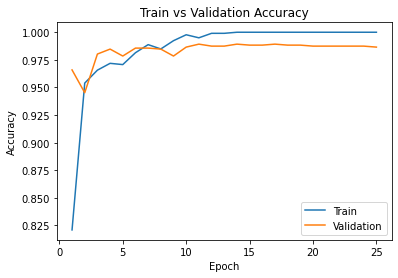

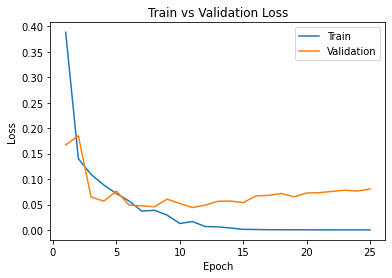

In [ ]:
model_path = get_model_name(training_params["network_name"], 
                            batch_size=training_params["batch_size"], 
                            learning_rate=training_params["learning_rate"], 
                            epoch=training_params["num_epochs"] - 1,
                            path_prefix=training_params["path_prefix"])

plot_training_curve(model_path)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

---

| Hyperparameter | 
| --- | 
| RNN output pooling method | 
| Number of hidden layers|
| Learning rate|
| Batch size|

| No. | Pooling | No. Hidden | lr | bs | val. acc. | Reasoning |
| --- | --- | --- | --- | --- | --- | --- | 
| 1 | Max Pooling | 0 | 1e-3 | 64 | 0.96 | Compare the difference between <br> max, average, and concat methods |
| 2 | Final Token | 0 | 1e-3 | 64 | 0.91 | Compare the difference between <br> max, average, and concat methods |
| 3 | Concat Max & Mean | 0 | 1e-3 | 64 | 0.99 | Compare the difference between <br> max, average, and concat methods. <br>The concat max & min method seems to<br> work the best. |
| 4 | Concat Max & Mean | 0 | 1e-3 | 512 | 0.98 | Increase the batch size for faster training |
| 5 | Concat Max & Mean | 0 | 1e-2 | 512 | 0.96 | Increase the learning rate to match the <br>larger batch size |
| 6 | Concat Max & Mean | 1 | 1e-3 | 64 | 0.99 | Added a hidden layer to see if it can help the <br>network learn more abstract features. I had to <br>use leaky ReLU because with ReLU, the training <br>did not converge.  |


In [24]:
class SpamNet2(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_classes):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.ident = torch.eye(vocab_size)
        self.name = "SpamNet2"

        self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2, 32)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.ident[x]
        x = x.to(device)

        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                         torch.mean(out, dim=1)], dim=1)
        # out = self.fc(out[:, -1, :])
        # out = self.fc(torch.max(out, dim=1)[0])
        out = F.leaky_relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [25]:
model = SpamNet2(vocab_size=len(text_field.vocab), 
                hidden_size=len(text_field.vocab), 
                num_classes=2).to(device)
training_params = {
    "net": model,
    "train_set": train,
    "val_set": valid,
    "path_prefix": "spamnet2_default",
    "network_name": model.__class__.__name__,
    "batch_size": 64,
    "learning_rate": 0.001,
    "num_epochs": 25,
    "num_workers": 2,
    "device": device

}
train_net(**training_params)

Epoch 1: Train acc: 0.5178193653376729, Train loss: 0.6936864880556913 |Validation acc: 0.11759425493716337, Validation loss: 0.7715349793434143
Epoch 2: Train acc: 0.8022782750203418, Train loss: 0.38919939006649956 |Validation acc: 0.9748653500897666, Validation loss: 0.14515948295593262
Epoch 3: Train acc: 0.934092758340114, Train loss: 0.19857449340394018 |Validation acc: 0.9622980251346499, Validation loss: 0.14915576577186584
Epoch 4: Train acc: 0.9485760781122864, Train loss: 0.152131143794155 |Validation acc: 0.966786355475763, Validation loss: 0.10712765902280807
Epoch 5: Train acc: 0.957526444263629, Train loss: 0.14364916523054397 |Validation acc: 0.9658886894075404, Validation loss: 0.10622607916593552
Epoch 6: Train acc: 0.9609438567941416, Train loss: 0.11589746466194539 |Validation acc: 0.9802513464991023, Validation loss: 0.07288841903209686
Epoch 7: Train acc: 0.9648494711147274, Train loss: 0.11011638224950616 |Validation acc: 0.9614003590664273, Validation loss: 0.12

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [36]:
def confusion(dataset):
  # Create a Dataset of only spam dataset examples
  spam = torchtext.legacy.data.Dataset(
      [e for e in dataset.examples if e.label == 1],
      dataset.fields)
  # Create a Dataset of only non-spam dataset examples
  nospam = torchtext.legacy.data.Dataset(
      [e for e in dataset.examples if e.label == 0],
      dataset.fields)

  tn = get_accuracy(model, nospam)
  fp = 1 - tn
  tp = get_accuracy(model, spam)
  fn = 1 - tp

  return tn, fp, tp, fn

In [37]:
model = SpamNet2(vocab_size=len(text_field.vocab), 
                hidden_size=len(text_field.vocab), 
                num_classes=2).to(device)

training_params = {
    "net": model,
    "train_set": train,
    "val_set": valid,
    "path_prefix": "spamnet2_default",
    "network_name": model.__class__.__name__,
    "batch_size": 64,
    "learning_rate": 0.001,
    "num_epochs": 25,
    "num_workers": 2,
    "device": device

}

model_path = get_model_name(training_params["network_name"], 
                            batch_size=training_params["batch_size"], 
                            learning_rate=training_params["learning_rate"], 
                            epoch=25 - 1,
                            path_prefix=training_params["path_prefix"])
state = torch.load(model_path)
model.load_state_dict(state)

_, fp, _, fn = confusion(valid)

print("False positive: ", fp * 100, "%")
print("False negative: ", fn * 100, "%")


False positive:  0.10172939979654627 %
False negative:  8.3969465648855 %


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

* Impact of false positive: missed messages due to the algorithm misclassifying non-spam messages to spam. 
* Impact of false negative: receive spam messages because the algorithm classified it as non-spam. 

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [53]:
model = SpamNet2(vocab_size=len(text_field.vocab), 
                hidden_size=len(text_field.vocab), 
                num_classes=2).to(device)

training_params = {
    "net": model,
    "train_set": train,
    "val_set": valid,
    "path_prefix": "spamnet2_default",
    "network_name": model.__class__.__name__,
    "batch_size": 64,
    "learning_rate": 0.001,
    "num_epochs": 25,
    "num_workers": 2,
    "device": device

}

model_path = get_model_name(training_params["network_name"], 
                            batch_size=training_params["batch_size"], 
                            learning_rate=training_params["learning_rate"], 
                            epoch=25 - 1,
                            path_prefix=training_params["path_prefix"])
state = torch.load(model_path)
model.load_state_dict(state)

test_acc = get_accuracy(model, test)
print("Test accuracy: ", test_acc * 100, "%")



torch.Size([1115, 446])
<class 'torch.Tensor'>
torch.int64
Test accuracy:  97.9372197309417 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [38]:
_, fp, _, fn = confusion(test)
print("False positive: ", fp * 100, "%")
print("False negative: ", fn * 100, "%")

False positive:  0.5175983436852993 %
False negative:  11.409395973154357 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [43]:
text_field.vocab.stoi[iter("hello")]

0

In [59]:
msg = "machine learning is sooo cool!"
input = torch.LongTensor([text_field.vocab.stoi[s] for s in msg]).unsqueeze(0)
input = input.to(device)

out = model(input)
m = nn.Softmax(dim=1)
pred = m(out).cpu().detach().numpy()[0][1]

print("Spam probability:", pred * 100, "%")

Spam probability: 0.19991581793874502 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

---
Spam detection is generally a difficult task. Because the tolerance of false positive is very low, as users never want to miss any messages. However, for applications that don't require a very low false positive rate, then the detection can be easy, since spam messages are usually associated with certain features such as keywords. 

A simple baseline model can be a fully connected neural network. Glove embeddings of each word can be used to tokenize the input, which is then concatenated and fed into a fully-connected network with non-linear activations. The output is a binary classification and we can use a Binary Cross Entropy loss function to train the network. 